# Abstract

[**hdf5plugin**](https://github.com/silx-kit/hdf5plugin) is a *Python* package (1) providing a set of [**HDF5**](https://portal.hdfgroup.org/display/HDF5/) compression filters (namely: blosc, bitshuffle, lz4, FCIDECOMP, ZFP, Zstandard) and (2) enabling their use from the *Python* programming language with [**h5py**](https://docs.h5py.org/) a thin, pythonic wrapper around `libHDF5`.

This presentation illustrates how to use **hdf5plugin** for reading and writing compressed datasets from *Python* and gives an overview of the different HDF5 compression filters it provides.

It also illustrates how the provided compression filters can be enabled to read compressed datasets from other (non-*Python*) application.

Finally, it discusses how **hdf5plugin** manages to distribute the HDF5 plugins for reuse with different `libHDF5`.

License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [ ]:
# Notebook requirements
# A recent version of Pillow is required!
%pip install numpy h5py hdf5plugin h5glance rise jupyterlab matplotlib ipympl Pillow

In [ ]:
%matplotlib inline

# Creates data.h5 used for demos
from matplotlib import pyplot as plt
import h5py
import hdf5plugin
import numpy
from PIL import Image
import urllib.request

url = "https://www.eiroforum.org/wp-content/uploads/pg-esrf-01.jpg"
filename = urllib.request.urlretrieve(url)[0]
image = numpy.array(Image.open(filename).convert("L"))
plt.imshow(image)

h5file = h5py.File("data.h5", mode="w")
h5file["copyright"] = "P.Ginter/ESRF"
h5file.attrs["url"] = url
h5file.create_dataset("/data", data=image)
h5file.create_dataset("/compressed_data_bitshuffle_lz4", data=image, **hdf5plugin.Bitshuffle())
h5file.close()

# Restart kernel once the file is created!

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

![ESRF logo](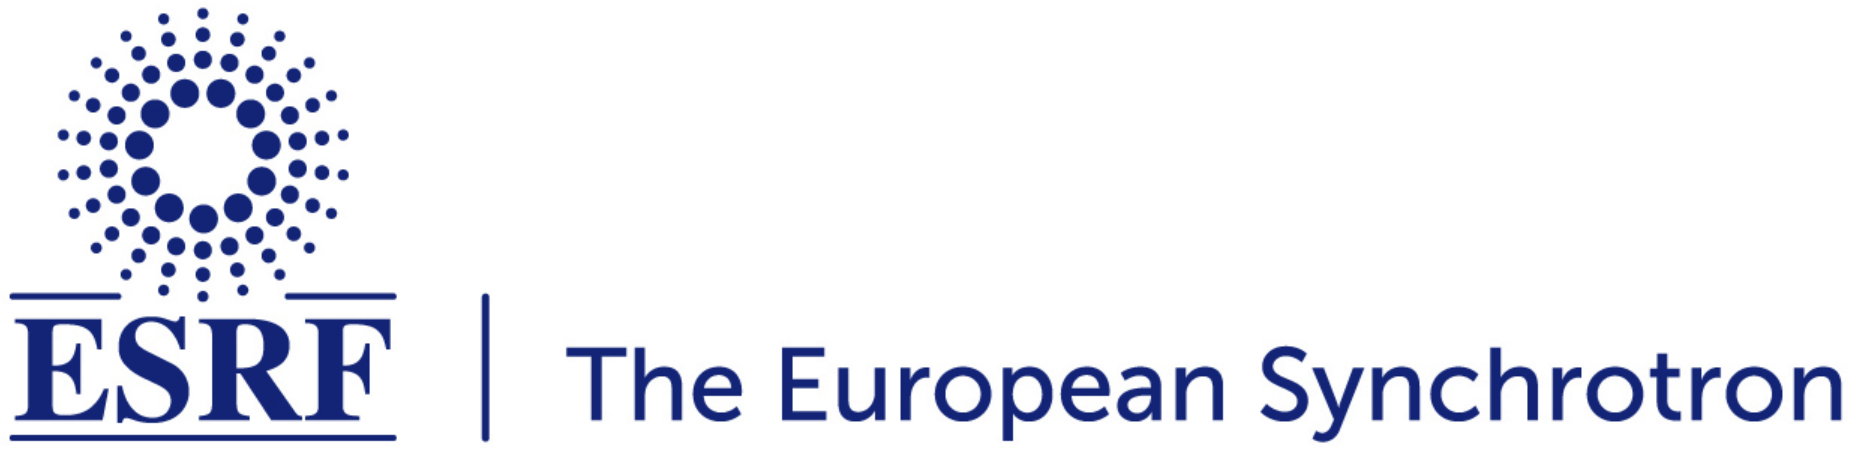 "ESRF logo")

# hdf5plugin

[**hdf5plugin**](https://github.com/silx-kit/hdf5plugin) packages a set of [HDF5](https://portal.hdfgroup.org/display/HDF5/) compression filters (namely: blosc, bitshuffle, lz4, FCIDECOMP, ZFP, Zstandard) and makes them usable from the Python programming language through [h5py](https://docs.h5py.org/).

[**h5py**](https://docs.h5py.org/) is a thin, pythonic wrapper around [HDF5](https://portal.hdfgroup.org/display/HDF5/).

&nbsp;

&nbsp;

Presenter: Thomas VINCENT

European HDF Users Group Summer 2021, July 7-8, 2021

In [2]:
from h5glance import H5Glance  # Browsing HDF5 files
H5Glance("data.h5")

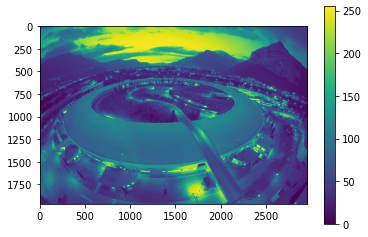

In [3]:
import h5py  # Pythonic HDF5 wrapper: https://docs.h5py.org/

h5file = h5py.File("data.h5", mode="r")  # Open HDF5 file in read mode
data = h5file["/data"][()]               # Access HDF5 dataset "/data"
plt.imshow(data); plt.colorbar()         # Display data

In [4]:
data = h5file["/compressed_data_bitshuffle_lz4"][()]  # Access compressed dataset

OSError: Can't read data (can't open directory: /usr/local/hdf5/lib/plugin)

## `hdf5plugin` usage

### Reading compressed datasets

To enable reading compressed datasets not supported by `libHDF5` and `h5py`:
Install **hdf5plugin** & import it.

In [ ]:
%%bash
pip3 install hdf5plugin

Or: `conda install -c conda-forge hdf5plugin`

In [5]:
import hdf5plugin

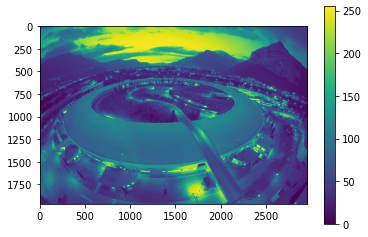

In [6]:
data = h5file["/compressed_data_bitshuffle_lz4"][()]  # Access datset
plt.imshow(data); plt.colorbar()                      # Display data

In [7]:
h5file.close()  # Close the HDF5 file

### Writing compressed datasets

When writing datasets with `h5py`, compression can be specified with: [h5py.Group.create_dataset](https://docs.h5py.org/en/stable/high/group.html?highlight=create_dataset#h5py.Group.create_dataset)

In [8]:
# Create a dataset with h5py without compression
h5file = h5py.File("new_file_uncompressed.h5", mode="w")
h5file.create_dataset("/data", data=data)
h5file.close()

In [9]:
# Create a compressed dataset
h5file = h5py.File("new_file_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_bitshuffle_lz4",
    data=data,
    compression=32008,  # bitshuffle/lz4 HDF5 filter identifier
    compression_opts=(0, 2)  # options: default number of elements/block, enable LZ4
)
h5file.close()

`hdf5plugin` provides some [helpers](http://www.silx.org/doc/hdf5plugin/latest/usage.html#write-compressed-datasets) to ease dealing with compression filter and options:

In [10]:
h5file = h5py.File("new_file_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_bitshuffle_lz4",
    data=data,
    **hdf5plugin.Bitshuffle()  # Or: **hdf5plugin.BitShuffle(lz4=True)
)
h5file.close()

In [ ]:
hdf5plugin.Bitshuffle?

In [12]:
H5Glance("new_file_bitshuffle_lz4.h5")

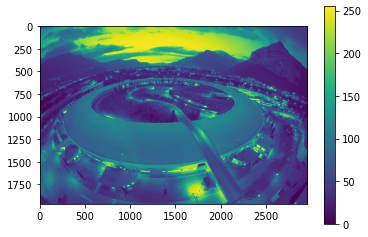

In [13]:
h5file = h5py.File("new_file_bitshuffle_lz4.h5", mode="r")
plt.imshow(h5file["/compressed_data_bitshuffle_lz4"][()]); plt.colorbar()
h5file.close()

In [14]:
!ls -l new_file*.h5

-rw-r--r--  1 tvincent  staff  4278852 Jul  8 14:25 new_file_bitshuffle_lz4.h5
-rw-r--r--  1 tvincent  staff  5832257 Jul  8 14:24 new_file_uncompressed.h5


## HDF5 compression filters

### Available through `h5py`

[Compression filters provided by h5py](https://docs.h5py.org/en/stable/high/dataset.html#lossless-compression-filters):

- Provided by `libhdf5`: **"gzip"** and eventually **"szip"** (optional)
- Bundled with `h5py`: [**"lzf"**](https://confluence.hdfgroup.org/display/support/Filters#Filters-32000)

Pre-compression filter: [Byte-Shuffle](https://docs.h5py.org/en/stable/high/dataset.html#shuffle-filter)

In [ ]:
h5file = h5py.File("new_file_shuffle_gzip.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_shuffle_gzip", data=data, shuffle=True, compression="gzip")
h5file.close()

### Provided by `hdf5plugin`

Additional compression filters provided by `hdf5plugin`: Bitshuffle, Blosc, FciDecomp, LZ4, ZFP, Zstandard.

6 out of the 25 [HDF5 registered filter plugins](https://confluence.hdfgroup.org/display/support/Registered+Filter+Plugins) as of June 2021.

In [ ]:
h5file = h5py.File("new_file_blosc.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_blosc",
    data=data,
    **hdf5plugin.Blosc(cname='zlib', clevel=5, shuffle=hdf5plugin.Blosc.SHUFFLE)
)
h5file.close()

#### General purpose lossless compression

- [Bitshuffle(nelems=0, lz4=True)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#bitshuffle) (Filter ID [32008](https://confluence.hdfgroup.org/display/support/Filters#Filters-32008)): **Bit**-Shuffle + LZ4
- [LZ4(nbytes=0)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#lz4) (Filter ID [32004](https://confluence.hdfgroup.org/display/support/Filters#Filters-32004))
- [Zstd()](http://www.silx.org/doc/hdf5plugin/latest/usage.html#zstd) (Filter ID [32015](https://confluence.hdfgroup.org/display/support/Filters#Filters-32015))
- [Blosc(cname='lz4', clevel=5, shuffle=1)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#blosc) (Filter ID [32001](https://confluence.hdfgroup.org/display/support/Filters#Filters-32001)):
  Based on c-blosc: A blocking, shuffling and lossless compression library.
  - Pre-compression shuffle: None, **Byte**-Shuffle, **Bit**-Shuffle
  - Compression: `blosclz`, `lz4`, `lz4hc`, `snappy` (**optional**, requires C++11), `zlib`, `zstd`

#### Specific compression

- [FciDecomp()](http://www.silx.org/doc/hdf5plugin/latest/usage.html#fcidecomp) (Filter ID [32018](https://confluence.hdfgroup.org/display/support/Filters#Filters-32018)): Based on JPEG-LS:
  - **Optional**: requires C++11
  - Data type: `(u)int8` or `(u)int16`
  - Chunk shape: "Image-like"; 2 or 3 dimensions with at least 16 pixels and at most 65535 rows and columns and at most 4 planes for 3D datasets.
- [ZFP(rate=None, precision=None, accuracy=None, reversible=False, minbits=None, maxbits=None, maxprec=None, minexp=None)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#zfp) (Filter ID [32013](https://confluence.hdfgroup.org/display/support/Filters#Filters-32013)): **Lossy**
  - Data type: `float32`, `float64`, `(u)int32`, `(u)int64`
  - Chunk shape: must have at most 4 non-unity dimensions

#### Benchmark

- Machine: 6 cores+hyperthreading (Intel(R) Xeon(R) CPU E5-1650 v3 @ 3.50GHz)
- Filesystem: RAM disk
- HDF5 chunk: 1 frame
- `hdf5plugin` built from source
- Diffraction tomography dataset: 100 frames from http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/kevlar.h5

![Benchmark](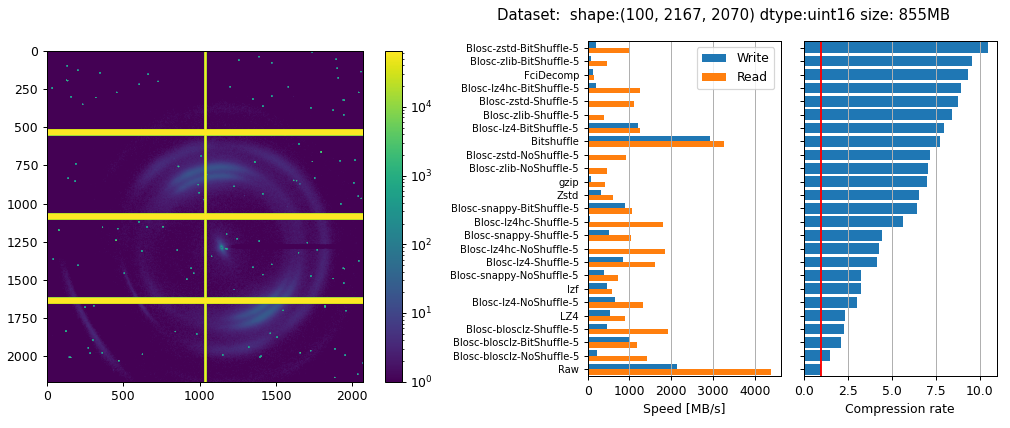 "Benchmark")

#### Equivalent filters

`Blosc` includes pre-compression filters and algorithms provided by other HDF5 compression filters:

- `LZ4()` => `Blosc("lz4", 9)`
- `Zstd()` => `Blosc("zstd", 2)`
- HDF5 shuffle  => `Blosc` with `shuffle=hdf5plugin.Blosc.SHUFFLE`
- `Bitshuffle()` => `Blosc("lz4", 5, hdf5plugin.Blosc.BITSHUFFLE)`...
  
  **Except for  OpenMP support** with `Bitshuffle`!

### Summary

Having different pre-compression filters and compression algorithms at hand offer different read/write speed versus compression rate (and eventually error rate) trade-offs.

Also to keep in mind availability/compatibility: `"gzip"` as included in `libHDF5` is the most compatible one (and also `"lzf"` as included in `h5py`).

## Using `hdf5plugin` filters with other applications

Note: With notebook, using **!** enables running shell commands

In [15]:
!h5dump -d /compressed_data_bitshuffle_lz4 -s "0,0" -c "5,10" data.h5 

HDF5 "data.h5" {
DATASET "/compressed_data_bitshuffle_lz4" {
   DATATYPE  H5T_STD_U8LE
   DATASPACE  SIMPLE { ( 1969, 2961 ) / ( 1969, 2961 ) }
   SUBSET {
      START ( 0, 0 );
      STRIDE ( 1, 1 );
      COUNT ( 5, 10 );
      BLOCK ( 1, 1 );
      DATA {
      }
   }
}
}


A solution: Set `HDF5_PLUGIN_PATH` environment variable to: `hdf5plugin.PLUGINS_PATH`

In [ ]:
# Directory where HDF5 compression filters are stored
hdf5plugin.PLUGINS_PATH

In [ ]:
# Retrieve hdf5plugin.PLUGINS_PATH from the command line
!python3 -c "import hdf5plugin; print(hdf5plugin.PLUGINS_PATH)" 

In [19]:
!ls `python3 -c "import hdf5plugin; print(hdf5plugin.PLUGINS_PATH)"`

libh5blosc.dylib     libh5fcidecomp.dylib libh5zfp.dylib
libh5bshuf.dylib     libh5lz4.dylib       libh5zstd.dylib


In [20]:
# Set HDF5_PLUGIN_PATH environment variable to hdf5plugin.PLUGINS_PATH
!HDF5_PLUGIN_PATH=`python3 -c "import hdf5plugin; print(hdf5plugin.PLUGINS_PATH)"` h5dump -d /compressed_data_bitshuffle_lz4 -s "0,0" -c "5,10" data.h5

HDF5 "data.h5" {
DATASET "/compressed_data_bitshuffle_lz4" {
   DATATYPE  H5T_STD_U8LE
   DATASPACE  SIMPLE { ( 1969, 2961 ) / ( 1969, 2961 ) }
   SUBSET {
      START ( 0, 0 );
      STRIDE ( 1, 1 );
      COUNT ( 5, 10 );
      BLOCK ( 1, 1 );
      DATA {
      (0,0): 53, 52, 53, 54, 54, 55, 55, 56, 56, 57,
      (1,0): 49, 50, 54, 55, 53, 54, 55, 56, 56, 58,
      (2,0): 50, 51, 54, 54, 53, 55, 56, 57, 58, 57,
      (3,0): 51, 54, 55, 54, 54, 55, 56, 57, 58, 59,
      (4,0): 53, 55, 54, 54, 56, 56, 58, 57, 57, 58
      }
   }
}
}


**Note**: Only works for reading compressed datasets, **not for writing!**

## Insights

### The Problem

For **reading** compressed datasets, compression filters do **NOT** need information from `libHDF5`. They work with the compressed stream.

For **writing** compressed datasets, some information about the dataset (e.g., data type size) can be needed by the filter (e.g., to shuffle the data). This information is retrieve through `libHDF5` C-API (e.g., [**H5Tget_size**](https://support.hdfgroup.org/HDF5/doc/RM/RM_H5T.html#Datatype-GetSize)).

Access to `libHDF5` C-API is needed, but linking compression filters with `libHDF5` is cumbersome in a dynamic environment like *Python*.

### On Windows

Symbols from dynamically loaded *Python* modules and libraries are accessible to others.

Register compression filter at C-level with `H5Zregister` (see [src/register_win32.c](https://github.com/silx-kit/hdf5plugin/blob/main/src/register_win32.c))

### On Linux, macos

In *Python*, symbols from dynamically loaded modules and libraries are **NOT** visible to others.

- Do not link filters with `libHDF5`.
- Instead, provide some function wrappers to replace `libHDF5` C-API and link the compression filter with those.

  - Those functions call `libHDF5` corresponding functions that are dynamically loaded at runtime.
  
- At runtime, we need to initialize the compression filter to load symbols dynamically from `libHDF5` used by `h5py` and use them from the function wrappers.

[src/hdf5_dl.c](https://github.com/silx-kit/hdf5plugin/blob/main/src/hdf5_dl.c):

```c
typedef size_t (* DL_func_H5Tget_size)(hid_t type_id);
static struct { /* Structure storing HDF5 function pointers */
    DL_func_H5Tget_size H5Tget_size;
} DL_H5Functions = {NULL};

/* Init wrapper by loading symbols from `libHDF5` */
int init_filter(const char* libname) {
    void * handle = dlopen(libname, RTLD_LAZY | RTLD_LOCAL);  /*Load libHDF5*/
    DL_H5Functions.H5Tget_size = (DL_func_H5Tget_size)dlsym(handle, "H5Tget_size");
}
```

```c
/* H5Tget_size libHDF5 C-API wrapper*/
size_t H5Tget_size(hid_t type_id) {
    if(DL_H5Functions.H5Tget_size != NULL) {
        return DL_H5Functions.H5Tget_size(type_id);
    } else {
        return 0;
    }
}
```

### Concluding remark

In the event the HDF5 compression filter API evolves, it would be great to take this into account to ease distribution of compression filters.

## A word about `hdf5plugin` license

The source code of `hdf5plugin` itself is licensed under the [MIT](https://github.com/silx-kit/hdf5plugin/blob/main/LICENSE) license...

It also embeds the source code of the provided compression filters and libraries which are licensed under [different open-source licenses](http://www.silx.org/doc/hdf5plugin/latest/information.html#license) (Apache, BSD-2, BSD-3, MIT, Zlib...) and copyrights.

# Conlusion

`hdf5plugin` provides additional HDF5 compression filters (namely: `Bitshuffle`, `Blosc`, `FciDecomp`, `LZ4`, `ZFP`, `Zstandard`) mainly for use with [h5py](https://docs.h5py.org/) but not only.

- Packaged for [**pip**](https://pypi.org/project/hdf5plugin/) and [**conda**](https://anaconda.org/conda-forge/hdf5plugin)
- Documentation: http://www.silx.org/doc/hdf5plugin/latest/
- Source code repository: https://github.com/silx-kit/hdf5plugin

**Credits to the** [**contributors**](https://github.com/silx-kit/hdf5plugin/graphs/contributors): [Thomas Vincent](https://github.com/t20100), [Armando Sole](https://github.com/vasole), [\@Florian-toll](https://github.com/Florian-toll), [\@fpwg](https://github.com/fpwg), [Jerome Kieffer](https://github.com/kif), [\@Anthchirp](https://github.com/Anthchirp), [\@mobiusklein](https://github.com/mobiusklein), [\@junyuewang](https://github.com/junyuewang)

Partially funded by the [PaNOSC](https://www.panosc.eu/) EU-project.

<img align="left" vertical-align="top" src="data:image/svg+xml,%3Csvg%20width%3D%2240.5%22%20height%3D%2227%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%3E%3Cdesc%3EEuropean%20flag%3C%2Fdesc%3E%3Cdefs%3E%3Cg%20id%3D%22s%22%3E%3Cg%20id%3D%22c%22%3E%3Cpath%20id%3D%22t%22%20transform%3D%22rotate%2818%203.1569%20-.5%29%22%20d%3D%22m0%200v1h0.5z%22%2F%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23t%22%2F%3E%3C%2Fg%3E%3Cg%20id%3D%22a%22%3E%3Cuse%20transform%3D%22rotate%2872%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23c%22%2F%3E%3Cuse%20transform%3D%22rotate%28144%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23c%22%2F%3E%3C%2Fg%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23a%22%2F%3E%3C%2Fg%3E%3C%2Fdefs%3E%3Crect%20width%3D%2240.5%22%20height%3D%2227%22%20fill%3D%22%23039%22%20stroke-width%3D%22.05%22%2F%3E%3Cg%20transform%3D%22matrix%281.5%2C0%2C0%2C1.5%2C20.25%2C13.5%29%22%20fill%3D%22%23fc0%22%3E%3Cuse%20y%3D%22-6%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20y%3D%226%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cg%20id%3D%22l%22%3E%3Cuse%20x%3D%22-6%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%28216%20-2.3442%20-2.1107%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%28144%2C-2.1107%2C-2.3442%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%2872%2C-4.6626%2C-2.0759%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%2872%20-5.0759%20.5335%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3C%2Fg%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23l%22%2F%3E%3C%2Fg%3E%3C%2Fsvg%3E"/>&nbsp;This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No. 823852.

# Thanks for your attention! Questions?